<a href="https://colab.research.google.com/github/ciepielajan/Multi-Class-Classification-NLP/blob/main/Detecting_intentions_MLP-clean-lemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Pobranie danych

In [1]:
# https://drive.google.com/file/d/1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq/view?usp=sharing
!gdown --id "1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq"

Downloading...
From: https://drive.google.com/uc?id=1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq
To: /content/user_intent.zip
100% 271k/271k [00:00<00:00, 41.6MB/s]


In [2]:
!unzip "user_intent.zip"

Archive:  user_intent.zip
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    
  inflating: validation.csv          


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

data_set_train = pd.read_csv("train.csv")
data_set_valid = pd.read_csv("validation.csv")

print(data_set_train.shape)
print(data_set_valid.shape)

print(data_set_train.columns)
print(data_set_valid.columns)

(13784, 2)
(700, 2)
Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


#### Podstawowy process text

In [4]:
import re
def process_text(sentence):
    sentence = re.sub('[A-Za-z0-9]+@[a-zA-z].[a-zA-Z]+', '', sentence)  # maile
    sentence = re.sub('(http[s]*:[/][/])[a-zA-Z0-9]+', '', sentence)  # linki
    sentence = re.sub(r"<[^>]+>", " ", sentence) # remove html tag
    sentence = re.sub(r"[^a-zA-Z\s]", "", sentence)  # remove punctuations and numbers   
    sentence = re.sub(r"\b[A-Za-z]{1}\b", "", sentence)  # remove single characters

    sentence = re.sub("^\s+|\s+$", "", sentence, flags=re.UNICODE) # Remove spaces both in the BEGINNING and in the END of a string:
    sentence = " ".join(re.split("\s+", sentence, flags=re.UNICODE))  # Remove ONLY DUPLICATE spaces:
    sentence = sentence.lower()
    
    return sentence

In [5]:
data_set_train["clean_text"] = data_set_train["text"].apply(lambda x: process_text(x))

#### `SpaCy` `Lemmatyzacja` 

In [6]:
import spacy

# załadowanie angielskiego CORE 
nlp = spacy.load('en_core_web_sm')

In [7]:
spacy.__version__

'2.2.4'

In [8]:
%%time
data_set_train["tokens_lemma"] = data_set_train["clean_text"].apply(lambda x: " ".join([str(i.lemma_ ) for i in nlp(x) if i.lemma_  != "-PRON-"  ]))

CPU times: user 1min 56s, sys: 189 ms, total: 1min 56s
Wall time: 1min 56s


In [9]:
data_set_train.sample(5)

,text,label,clean_text,tokens_lemma
4508,Find a TV series called Dirty Politics.,SearchCreativeWork,find tv series called dirty politics,find tv series call dirty politic
12707,"Can you get the TV show, ENTER THE MATRIX?",SearchCreativeWork,can you get the tv show enter the matrix,can get the tv show enter the matrix
1367,What's the weather for McCracken in Niger,GetWeather,whats the weather for mccracken in niger,what s the weather for mccracken in niger
5034,I want to watch the TV show Tales from Space: ...,SearchCreativeWork,want to watch the tv show tales from space abo...,want to watch the tv show tale from space abou...
3583,Tell me if it'll be rainy here on Dec. the 25t...,GetWeather,tell me if itll be rainy here on dec the th,tell if will be rainy here on dec the th


In [10]:
id_intention = 6
print("Surowy tekst")
print(data_set_train["text"].iloc[id_intention])
print("Po oczyszczeniu")
print(data_set_train["clean_text"].iloc[id_intention])
print("Po lematyzacji")
print(data_set_train["tokens_lemma"].iloc[id_intention])

Surowy tekst
Book a table for 10 people at a restaurant which offers internet.
Po oczyszczeniu
book table for people at restaurant which offers internet
Po lematyzacji
book table for people at restaurant which offer internet


#### `LabelEncoder` oraz `to_categorical`

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical 


labelencoder = LabelEncoder()
data_set_train["labelencoder"] = labelencoder.fit_transform(data_set_train["label"])

dummy_y = to_categorical(data_set_train["labelencoder"], dtype ="float32")

data_set_train[["clean_text","label","labelencoder"]].head(5)

,clean_text,label,labelencoder
0,find cinema nearest for films,SearchScreeningEvent,6
1,give the current series two stars,RateBook,4
2,find the good girl at movie house,SearchScreeningEvent,6
3,please make reservations for three at kosher t...,BookRestaurant,1
4,what is the forecast for here one second from now,GetWeather,2


In [12]:
dummy_y.shape

(13784, 7)

In [13]:
id_intention = 6
print("Sprawdzenie poprawności LabelEncoder i to_categorical \n")
print("Label - ", data_set_train["label"].iloc[id_intention])
print("LabelEncoder - ", data_set_train["labelencoder"].iloc[id_intention])
print()
print("to_categorical - ", dummy_y[id_intention])
print()
print("return to LabelEncoder - ",np.argmax(dummy_y[id_intention], axis=-1))
print("return to Label - ",labelencoder.inverse_transform([np.argmax(dummy_y[id_intention], axis=-1)]))

Sprawdzenie poprawności LabelEncoder i to_categorical 

Label -  BookRestaurant
LabelEncoder -  1

to_categorical -  [0. 1. 0. 0. 0. 0. 0.]

return to LabelEncoder -  1
return to Label -  ['BookRestaurant']


#### Zdefiniowanie X i y

In [14]:
X = data_set_train["tokens_lemma"]
y = dummy_y

In [15]:
X.shape, y.shape

((13784,), (13784, 7))

#### Podział zbioru 

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11027,), (2757,), (11027, 7), (2757, 7))

#### `Tokenizer` i `pad_sequences`

In [18]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [19]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 7
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding="post", truncating="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", truncating="post", maxlen=maxlen)

In [20]:
from keras.models import Sequential
from keras.layers import Flatten, SimpleRNN, Dense
from keras.layers.embeddings import Embedding
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen))  
model.add(Flatten())
model.add(Dense(7, activation="softmax")) # sigmoid / softmax
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 100)            912200    
_________________________________________________________________
flatten (Flatten)            (None, 700)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 4907      
Total params: 917,107
Trainable params: 917,107
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          verbose=1)

history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=64, 
                    validation_split=0.2, 
                    callbacks = [EarlyStop] )
scores = model.evaluate(X_test, y_test)
print(f"Accuracy {scores[1] * 100}")

Epoch 1/20
138/138 [==============================] - 3s 14ms/step - loss: 1.5909 - accuracy: 0.6653 - val_loss: 0.4275 - val_accuracy: 0.9383
Epoch 2/20
138/138 [==============================] - 1s 10ms/step - loss: 0.3034 - accuracy: 0.9531 - val_loss: 0.1734 - val_accuracy: 0.9592
Epoch 3/20
138/138 [==============================] - 1s 10ms/step - loss: 0.1157 - accuracy: 0.9817 - val_loss: 0.1207 - val_accuracy: 0.9701
Epoch 4/20
138/138 [==============================] - 1s 10ms/step - loss: 0.0676 - accuracy: 0.9890 - val_loss: 0.0998 - val_accuracy: 0.9723
Epoch 5/20
138/138 [==============================] - 1s 10ms/step - loss: 0.0461 - accuracy: 0.9907 - val_loss: 0.0899 - val_accuracy: 0.9737
Epoch 6/20
138/138 [==============================] - 1s 11ms/step - loss: 0.0322 - accuracy: 0.9940 - val_loss: 0.0838 - val_accuracy: 0.9742
Epoch 7/20
138/138 [==============================] - 1s 11ms/step - loss: 0.0244 - accuracy: 0.9958 - val_loss: 0.0794 - val_accuracy: 0.9755

In [23]:
print(f"Accuracy {scores[1] * 100}")

Accuracy 97.71490693092346


#### Predykcja na zbiorze validacyjnym

In [24]:
# oczysczenie danych
data_set_valid["clean_text"] = data_set_valid["text"].apply(lambda x: process_text(x))

# lematyzacja
data_set_valid["tokens_lemma"] = data_set_valid["clean_text"].apply(lambda x: " ".join([str(i.lemma_ ) for i in nlp(x) if i.lemma_  != "-PRON-"  ]))

# labelencoder 
data_set_valid["labelencoder"] = labelencoder.fit_transform(data_set_valid["label"])

# tokenizacja weg przetrenowanego już tokenizera
X_validate = tokenizer.texts_to_sequences(data_set_valid["clean_text"])

# pad sequel
X_validate = pad_sequences(X_validate, padding="post", truncating="post", maxlen=maxlen)
X_validate

array([[  12,  421,   44, ...,    1,   62,    0],
       [ 220,  285,   19, ..., 1531,    3,  383],
       [  12,    1,  254, ...,    4,   47,   96],
       ...,
       [  23,    1,   79, ...,    0,    0,    0],
       [  12,    1,   21, ...,    4, 2553,    0],
       [  42,   37,    4, ...,  146,  374,    2]], dtype=int32)

In [25]:
dummy_y_valid = data_set_valid["labelencoder"].values
dummy_y_valid[:5]

array([6, 3, 2, 0, 6])

In [26]:
# Sprawdzenie rozmiaru zbiorów validacyjnego
X_validate.shape, dummy_y_valid.shape

((700, 7), (700,))

In [27]:
predicted_lstm_val = np.argmax(model.predict(X_validate), axis=-1)
predicted_lstm_val[:5]

array([6, 3, 2, 0, 6])

#### Rozkodowanie przewidzianych i prawidłowych etykiet

In [28]:
y_pred = labelencoder.inverse_transform(predicted_lstm_val)
y_pred = pd.Series(y_pred)
y_pred.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

In [29]:
y_val = labelencoder.inverse_transform(dummy_y_valid)
y_val = pd.Series(y_val)
y_val.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

#### `Confusion matrix`

In [30]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

Accuracy: 0.96
F1_score: 0.96
                      precision    recall  f1-score   support

       AddToPlaylist       0.98      1.00      0.99       100
      BookRestaurant       0.97      0.98      0.98       100
          GetWeather       0.96      0.98      0.97       100
           PlayMusic       0.99      0.97      0.98       100
            RateBook       0.99      1.00      1.00       100
  SearchCreativeWork       0.87      1.00      0.93       100
SearchScreeningEvent       0.99      0.80      0.88       100

            accuracy                           0.96       700
           macro avg       0.96      0.96      0.96       700
        weighted avg       0.96      0.96      0.96       700



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

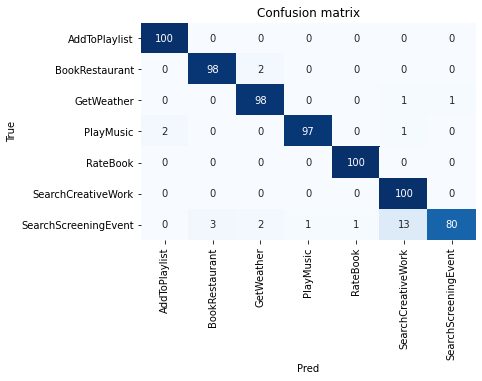

In [31]:
classes = np.unique(y_val)

print('Accuracy:', round(accuracy_score(y_val, y_pred),2))
print('F1_score:', round(f1_score(y_val, y_pred, average='weighted'),2))

print(classification_report(y_val, y_pred))
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

#### Zapoznanie się z błędnymi predykcjami 

In [45]:
indexes = []
for i, phrase in enumerate(y_pred):
  if phrase == 'SearchCreativeWork':
    if y_val[i] == 'SearchScreeningEvent':
      indexes.append(i)
print(indexes)

[6, 125, 343, 346, 381, 557, 568, 590, 611, 615, 648, 680, 689]


In [46]:
for i in indexes:
  print(f"----------------------------\nTekst komendy:\n{data_set_valid['text'][i]}")
  print(f"Oczyszczona komenda:\n{data_set_valid['tokens_lemma'][i]}")
  print(f'True category: {y_val[i]}')
  print(f'Predicted category: {y_pred[i]}')
  print("\n")

----------------------------
Tekst komendy:
I want to see While the Sun Shines at the closest movie house.
Oczyszczona komenda:
want to see while the sun shine at the close movie house
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
what are the times for The Gingerbread Man
Oczyszczona komenda:
what be the time for the gingerbread man
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
I want to see Married to the Enemy 2 at a cinema.
Oczyszczona komenda:
want to see marry to the enemy at cinema
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
I want to see Those Kids from Town, when will it be showing?
Oczyszczona komenda:
want to see those kid from town when will be show
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


--------------------------

In [47]:
indexes = data_set_valid[data_set_valid["label"]=="SearchCreativeWork"]["label"].index

for i in indexes:
  print(f"----------------------------\nTekst komendy:\n{data_set_valid['text'][i]}")
  print(f"Oczyszczona komenda:\n{data_set_valid['tokens_lemma'][i]}")
  print(f'True category: {y_val[i]}')
  print(f'Predicted category: {y_pred[i]}')
  print("\n")

----------------------------
Tekst komendy:
Find the movie Splendor in the Grass
Oczyszczona komenda:
find the movie splendor in the grass
True category: SearchCreativeWork
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
Please find me the saga, The Deep Six.
Oczyszczona komenda:
please find the saga the deep six
True category: SearchCreativeWork
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
Can you find me The Ridiculous 6 book?
Oczyszczona komenda:
can find the ridiculous book
True category: SearchCreativeWork
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
Please get me the Dead Soul saga.
Oczyszczona komenda:
please get the dead soul saga
True category: SearchCreativeWork
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
Please look up the song The Mad Magician.
Oczyszczona komenda:
please look up the song the mad magician
True category


#### Wnioski: 
> Model ma tendencję do faryzowania etykiety `SearchCreativeWork` kosztem `SearchScreeningEvent`. Świadczy o tym 100% skutczeność predykcji `SearchCreativeWork` przy 80% skuteczności predykcji `SearchScreeningEvent`. 

